# Quarter-five-spot example
The quarter-five-spot is a standard test problem that simulates 1/4 of the
five spot well pattern by assuming axial symmetry. The problem contains an
injector in one corner and the producer in the opposing corner, with a
significant volume of fluids injected into the domain.

In [1]:
using JutulDarcy, Jutul
nx = 50

50

## Setup
We define a function that, for a given porosity field, computes a solution
with an estimated permeability field. For assumptions and derivation of the
specific form of the Kozeny-Carman relation used in this example, see [Lie,
Knut-Andreas. An introduction to reservoir simulation using MATLAB/GNU Octave:
User guide for the MATLAB Reservoir Simulation Toolbox (MRST). Cambridge
University Press, 2019, Section 2.5.2](https://doi.org/10.1017/9781108591416)

In [2]:
function perm_kozeny_carman(Φ)
    return ((Φ^3)*(1e-5)^2)/(0.81*72*(1-Φ)^2);
end

function simulate_qfs(porosity = 0.2)
    Dx = 1000.0
    Dz = 10.0
    Darcy = 9.869232667160130e-13
    Darcy, bar, kg, meter, Kelvin, day, sec = si_units(:darcy, :bar, :kilogram, :meter, :Kelvin, :day, :second)

    mesh = CartesianMesh((nx, nx, 1), (Dx, Dx, Dz))
    K = perm_kozeny_carman.(porosity)
    domain = reservoir_domain(mesh, permeability = K, porosity = porosity)
    Inj = setup_vertical_well(domain, 1, 1, name = :Injector);
    Prod = setup_vertical_well(domain, nx, nx, name = :Producer);
    phases = (LiquidPhase(), VaporPhase())
    rhoLS = 1000.0*kg/meter^3
    rhoGS = 700.0*kg/meter^3
    rhoS = [rhoLS, rhoGS]
    sys = ImmiscibleSystem(phases, reference_densities = rhoS)
    model, parameters = setup_reservoir_model(domain, sys, wells = [Inj, Prod])
    c = [1e-6/bar, 1e-6/bar]
    ρ = ConstantCompressibilityDensities(p_ref = 150*bar, density_ref = rhoS, compressibility = c)
    kr = BrooksCoreyRelativePermeabilities(sys, [2.0, 2.0])
    replace_variables!(model, PhaseMassDensities = ρ, RelativePermeabilities = kr);

    state0 = setup_reservoir_state(model, Pressure = 150*bar, Saturations = [1.0, 0.0])
    dt = repeat([30.0]*day, 12*10)
    dt = vcat([0.1, 1.0, 10.0], dt)
    inj_rate = Dx*Dx*Dz*0.2/sum(dt) # 1 PVI if average porosity is 0.2

    rate_target = TotalRateTarget(inj_rate)
    I_ctrl = InjectorControl(rate_target, [0.0, 1.0], density = rhoGS)
    bhp_target = BottomHolePressureTarget(50*bar)
    P_ctrl = ProducerControl(bhp_target)
    controls = Dict()
    controls[:Injector] = I_ctrl
    controls[:Producer] = P_ctrl
    forces = setup_reservoir_forces(model, control = controls)
    return simulate_reservoir(state0, model, dt, parameters = parameters, forces = forces, info_level = -1)
end

simulate_qfs (generic function with 2 methods)

## Simulate base case
This will give the solution with uniform porosity of 0.2.

In [3]:
ws, states, report_time = simulate_qfs()

ReservoirSimResult with 123 entries:

  wells (2 present):
    :Producer
    :Injector
    Results per well:
       :Vapor_mass_rate => Vector{Float64} of size (123,)
       :lrat => Vector{Float64} of size (123,)
       :orat => Vector{Float64} of size (123,)
       :control => Vector{Symbol} of size (123,)
       :bhp => Vector{Float64} of size (123,)
       :Liquid_mass_rate => Vector{Float64} of size (123,)
       :mass_rate => Vector{Float64} of size (123,)
       :rate => Vector{Float64} of size (123,)
       :grat => Vector{Float64} of size (123,)

  states (Vector with 123 entries, reservoir variables for each state)
    :Saturations => Matrix{Float64} of size (2, 2500)
    :Pressure => Vector{Float64} of size (2500,)
    :TotalMasses => Matrix{Float64} of size (2, 2500)

  time (report time for each state)
     Vector{Float64} of length 123

  result (extended states, reports)
     SimResult with 123 entries

  extra
     Dict{Any, Any} with keys :simulator, :config

  Complet

### Plot the solution of the base case
We observe a radial flow pattern initially, before coning occurs near the
producer well once the fluid has reached the opposite corner. The uniform
permeability and porosity gives axial symmetry at $x=y$.

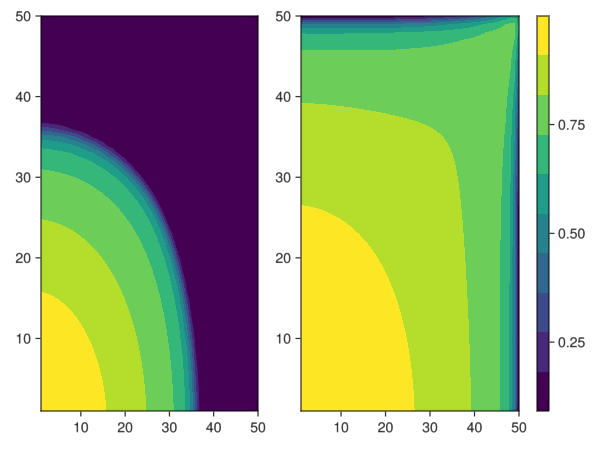

In [4]:
using GLMakie
to_2d(x) = reshape(vec(x), nx, nx)
get_sat(state) = to_2d(state[:Saturations][2, :])
nt = length(report_time)
fig = Figure()
h = nothing
ax = Axis(fig[1, 1])
h = contourf!(ax, get_sat(states[nt÷3]))
ax = Axis(fig[1, 2])
h = contourf!(ax, get_sat(states[nt]))
Colorbar(fig[1, end+1], h)
fig

## Create 10 realizations
We create a small set of realizations of the same model, with porosity that is
uniformly varying between 0.05 and 0.3. This is not especially sophisticated
geostatistics - for a more realistic approach, take a look at
[GeoStats.jl](https://juliaearth.github.io/GeoStats.jl). The main idea is to
get significantly different flow patterns as the porosity and permeability
changes.

In [5]:
N = 10
saturations = []
wells = []
report_step = nt
for i = 1:N
    poro = 0.05 .+ 0.25*rand(Float64, (nx*nx))
    ws, states, rt = simulate_qfs(poro)
    push!(wells, ws)
    push!(saturations, get_sat(states[report_step]))
end

### Plot the oil rate at the producer over the ensemble

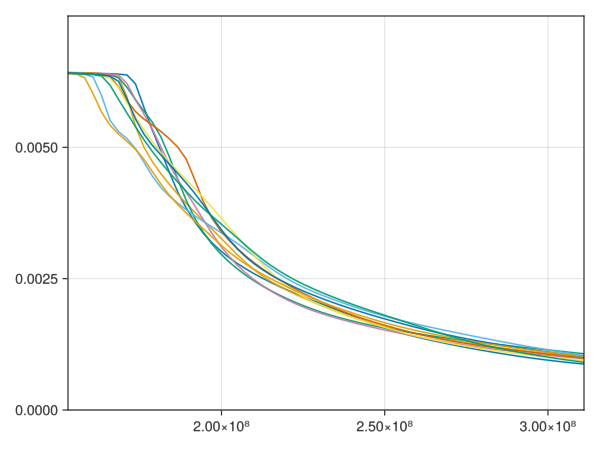

In [6]:
using Statistics
fig = Figure()
ax = Axis(fig[1, 1])
for i = 1:N
    ws = wells[i]
    q = -ws[:Producer][:orat]
    lines!(ax, report_time, q)
end
xlims!(ax, [mean(report_time), report_time[end]])
ylims!(ax, 0, 0.0075)
fig

### Plot the average saturation over the ensemble

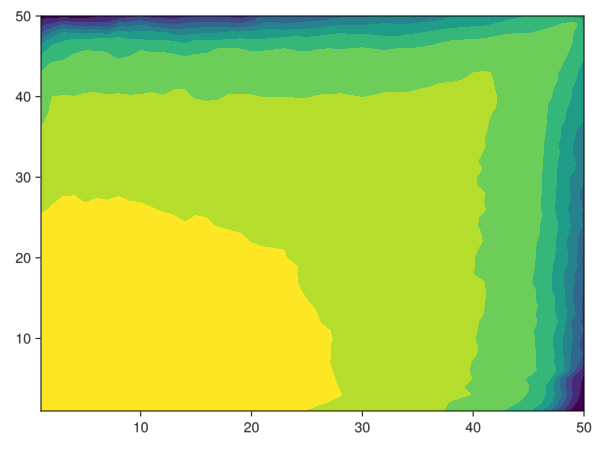

In [7]:
avg = mean(saturations)
fig = Figure()
h = nothing
ax = Axis(fig[1, 1])
h = contourf!(ax, avg)
fig

### Plot the isocontour lines over the ensemble

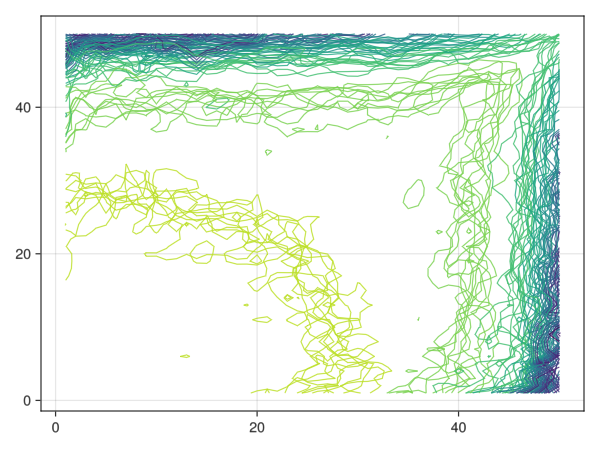

In [8]:
fig = Figure()
h = nothing
ax = Axis(fig[1, 1])
for s in saturations
    contour!(ax, s, levels = 0:0.1:1)
end
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*